In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [8]:
torch.device

torch.device

In [9]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="mps"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

In [10]:
diff = Diffusion()

In [12]:
diff.alpha_hat

tensor([9.9990e-01, 9.9978e-01, 9.9964e-01, 9.9948e-01, 9.9930e-01, 9.9910e-01,
        9.9888e-01, 9.9864e-01, 9.9838e-01, 9.9811e-01, 9.9781e-01, 9.9749e-01,
        9.9715e-01, 9.9679e-01, 9.9641e-01, 9.9602e-01, 9.9560e-01, 9.9516e-01,
        9.9471e-01, 9.9423e-01, 9.9374e-01, 9.9322e-01, 9.9269e-01, 9.9213e-01,
        9.9156e-01, 9.9097e-01, 9.9035e-01, 9.8972e-01, 9.8907e-01, 9.8840e-01,
        9.8771e-01, 9.8700e-01, 9.8627e-01, 9.8553e-01, 9.8476e-01, 9.8398e-01,
        9.8317e-01, 9.8235e-01, 9.8151e-01, 9.8065e-01, 9.7977e-01, 9.7887e-01,
        9.7795e-01, 9.7702e-01, 9.7606e-01, 9.7509e-01, 9.7410e-01, 9.7309e-01,
        9.7206e-01, 9.7102e-01, 9.6995e-01, 9.6887e-01, 9.6777e-01, 9.6665e-01,
        9.6551e-01, 9.6436e-01, 9.6319e-01, 9.6200e-01, 9.6079e-01, 9.5956e-01,
        9.5832e-01, 9.5706e-01, 9.5578e-01, 9.5449e-01, 9.5318e-01, 9.5185e-01,
        9.5050e-01, 9.4914e-01, 9.4776e-01, 9.4636e-01, 9.4494e-01, 9.4351e-01,
        9.4207e-01, 9.4060e-01, 9.3912e-

In [25]:
def pos_encoding(t, channels):
    inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device="cpu").float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return inv_freq, pos_enc

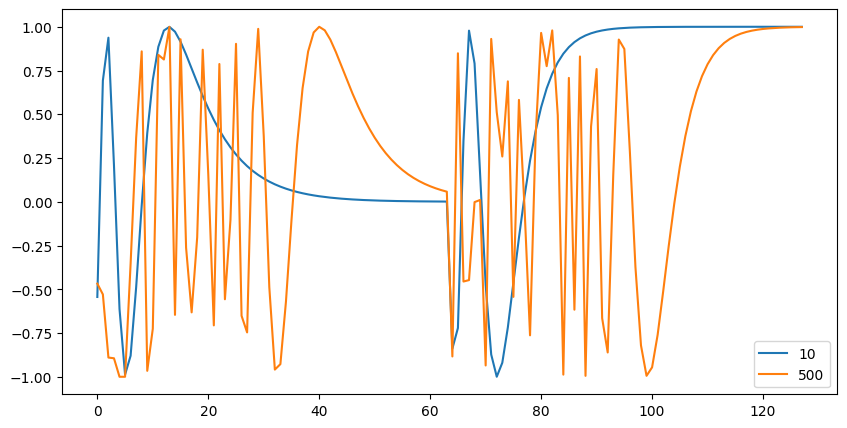

In [33]:
plt.figure(figsize=(10, 5))
for i in [10, 500]:
    inv_freq, t_emb = pos_encoding(torch.tensor(i), 128)
    plt.plot(t_emb.cpu().numpy().flatten(), label=i)
plt.legend()
plt.show()

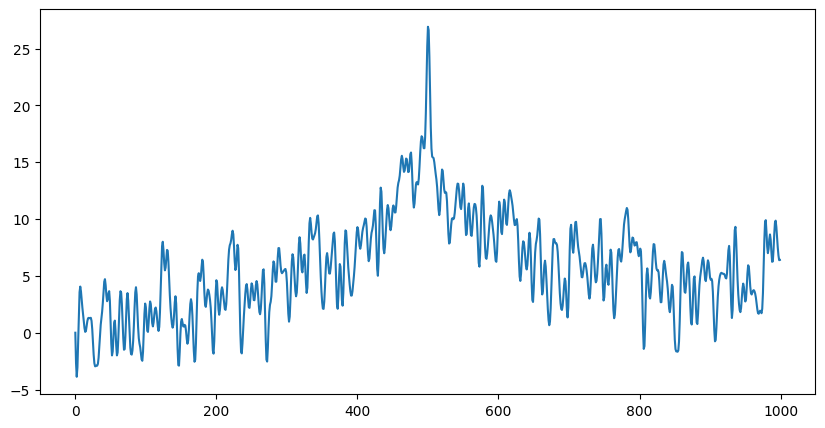

In [57]:
plt.figure(figsize=(10, 5))
_, t_emb_0 = pos_encoding(torch.tensor(500), 128)

dots = []
for i in range(0, 1000):
    _, t_emb = pos_encoding(torch.tensor(i), 128)

    dots.append((t_emb[:, :64] * t_emb_0[:, :64]).sum())

plt.plot(dots)
plt.show()

In [58]:
beta = torch.linspace(1e-4, 0.02, 1000)
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

In [ ]:
images = torch.randn(3, 3, 256, 256)
alpha = torch.randn(3, 1, 1, 1)

(alpha * images).shape

RuntimeError: The size of tensor a (3) must match the size of tensor b (4) at non-singleton dimension 0

In [68]:
torch.cumprod(torch.arange(1, 5), dim=0)

tensor([ 1,  2,  6, 24])

In [42]:
inv_freq, t_emb_5 = pos_encoding(torch.tensor(5), 128)
inv_freq, t_emb_100 = pos_encoding(torch.tensor(100), 128)
inv_freq, t_emb_500 = pos_encoding(torch.tensor(1000), 128)

In [44]:
(t_emb_5 * t_emb_100).sum(), (t_emb_5 * t_emb_500).sum()

(tensor(26.3583), tensor(14.7295))

In [4]:
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start**0.5,
                beta_end**0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "warmup10":
        betas = _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, 0.1)
    elif beta_schedule == "warmup50":
        betas = _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, 0.5)
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas


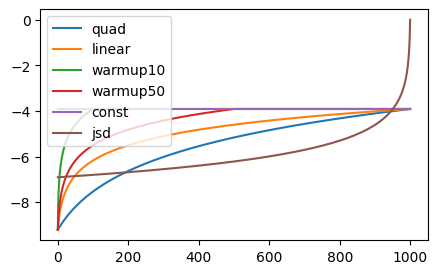

In [18]:
name = [
    "quad",
    "linear",
    "warmup10",
    "warmup50",
    "const",
    "jsd"
]
plt.figure(figsize=(5,3))
for n in name:
    betas = get_beta_schedule(beta_schedule=n,
                    beta_start=0.0001,
                    beta_end=0.02,
                    num_diffusion_timesteps=1000)

    plt.plot(np.log(betas), label=n)
plt.legend()
plt.show()

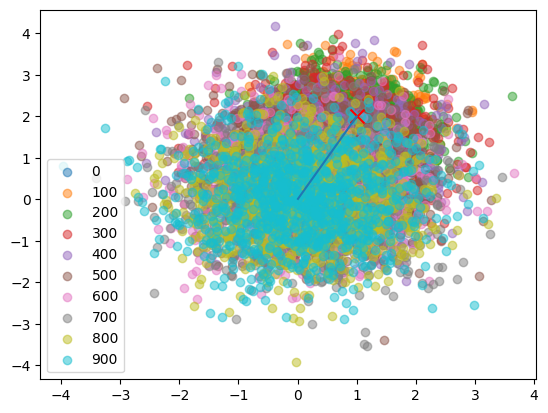

In [52]:
betas = get_beta_schedule(beta_schedule="linear",
                          beta_start=0.0001,
                          beta_end=0.02,
                          num_diffusion_timesteps=1000)

alphas = 1 - betas

alphas_cumprod = np.cumprod(alphas)

sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)

one_minus_sqrt_alphas_cumprod = np.sqrt(1 - alphas_cumprod)

mus = []
x_0 = np.array([1,2])
for t, (mu, std) in enumerate(zip(sqrt_alphas_cumprod, one_minus_sqrt_alphas_cumprod)):

    s = np.random.multivariate_normal(mu * x_0, std * np.eye(x_0.shape[0]), 1000)

    mus.append(mu * x_0)

    if t % 100 == 0:

        plt.scatter(s[:, 0], s[:, 1], label=t, alpha=0.5)
mus = np.array(mus)
plt.scatter(x_0[0], x_0[1], s=100, c="r", marker="x")
plt.plot(mus[:, 0], mus[:, 1])
plt.legend()

plt.show()

In [34]:
s[

array([1.68188432, 1.61469822])